# **LoanGuard: Model Training** 🚀

## **Objective**
This notebook focuses on building and evaluating machine learning models for **loan default prediction** using Lending Club data. The goal is to create a robust model that can accurately classify borrowers into **"Fully Paid"** and **"Charged Off"** categories, helping lenders make informed decisions.

## **Models to be Implemented**
- ✔️ **Baseline Models**: Logistic Regression, Naive Bayes, K-Nearest Neighbors (KNN)
- ✔️ **Tree-Based Models**: Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost
- ✔️ **Artificial Neural Network (ANN)**: Deep learning-based approach for capturing complex patterns
- ✔️ **Stacking Ensemble**: Combining multiple models for better predictive power

## **Expected Outcome**
By the end of this notebook, we aim to have a **high-performing loan default prediction model** that balances **accuracy, precision, and recall**, ensuring minimal false negatives (misclassified defaulters).

---

### 1. **Loading Libs**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import time
import os
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### 2. **Load and Preprocess Data**

In [2]:
# Load train and test data
df_train = pd.read_csv('../data/processed/train.csv')
df_test = pd.read_csv('../data/processed/test.csv')

In [3]:
def encode_target(df):
    """Encode loan_status: Fully Paid -> 0, Charged Off -> 1"""
    df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
    return df

In [4]:
df_train = encode_target(df_train)
df_test = encode_target(df_test)

In [5]:
# Define features and target
X_train = df_train.drop(columns=['loan_status'])
y_train = df_train['loan_status']
X_test = df_test.drop(columns=['loan_status'])
y_test = df_test['loan_status']

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. Define Model Evaluation Function

In [ ]:
def evaluate_model(model_name, y_test, y_pred, model, X_test):
    print("\n================================================")
    print(f"📊 {model_name} Performance")
    print("================================================")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
    print(f"F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred) * 100:.2f}%")
    print("------------------------------------------------")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("------------------------------------------------")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("================================================\n")
    
    # Display Confusion Matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    # plt.title(f"Confusion Matrix - {model_name}")
    # plt.show()
    
    # Display ROC Curve
    # RocCurveDisplay.from_estimator(model, X_test, y_test)
    # plt.title(f"ROC Curve - {model_name}")
    # plt.show()

### 4. Model training

In [8]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": LGBMClassifier(device="gpu"),
    "CatBoost": CatBoostClassifier(task_type="GPU", verbose=0)
}

In [9]:
# Dictionary to store scores
scores_dict = {}
model_results = {}

In [10]:
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    evaluate_model(name, y_test, y_pred, model, X_test)
    model_results[name] = accuracy_score(y_test, y_pred)
    
    scores_dict[name] = {
        'Train': roc_auc_score(y_train, model.predict(X_train)) * 100,
        'Test': roc_auc_score(y_test, y_pred) * 100
    }

Training Logistic Regression...
Time taken: 341.79 seconds

📊 Logistic Regression Performance
Accuracy: 88.92%
------------------------------------------------
Precision: 93.97%
Recall: 46.26%
F1 Score: 62.00%
ROC AUC Score: 72.77%
------------------------------------------------
Confusion Matrix:
[[104187    756]
 [ 13693  11787]]
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94    104943
           1       0.94      0.46      0.62     25480

    accuracy                           0.89    130423
   macro avg       0.91      0.73      0.78    130423
weighted avg       0.89      0.89      0.87    130423


Training Naive Bayes...
Time taken: 0.77 seconds

📊 Naive Bayes Performance
Accuracy: 86.77%
------------------------------------------------
Precision: 70.72%
Recall: 55.05%
F1 Score: 61.91%
ROC AUC Score: 74.76%
------------------------------------------------
Con

In [11]:
scores_df = pd.DataFrame(scores_dict).T

In [19]:
scores_df.hvplot.barh(
    width=700, height=500, 
    title="Train vs Test ROC Scores of ML Models", xlabel="ROC AUC Score (%)", 
    alpha=0.6, legend='top', stacked=False
)

:Bars   [index,Variable]   (value)

### 5. Model Comparison & Selection

In [21]:
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model  Accuracy
6             LightGBM  0.889728
7             CatBoost  0.889682
0  Logistic Regression  0.889214
4        Random Forest  0.889176
5              XGBoost  0.888402
2                  KNN  0.872193
1          Naive Bayes  0.867654
3        Decision Tree  0.829302


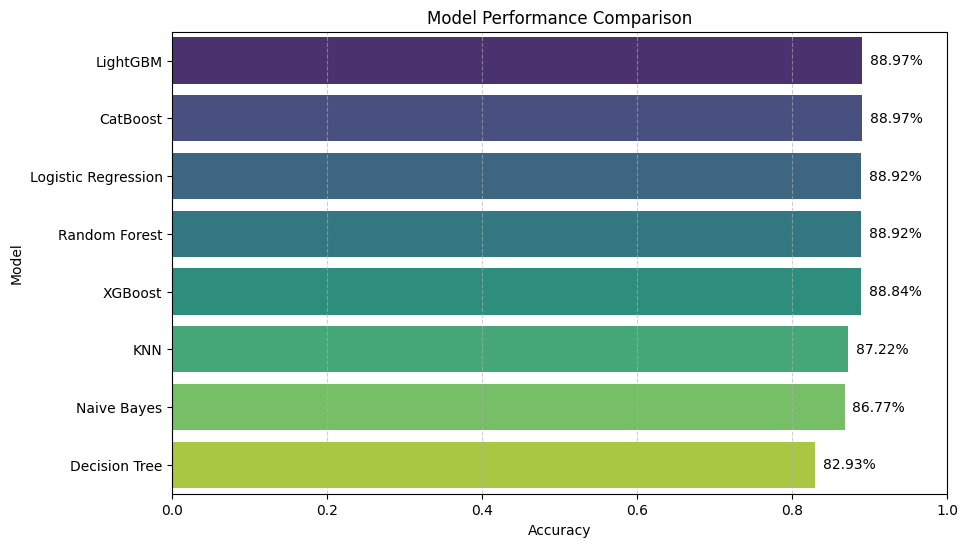

In [ ]:
# 📊 Visualization of Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df["Accuracy"], y=results_df["Model"], palette="viridis", hue=results_df["Model"], legend=False)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Display the accuracy values on the bars
for index, value in enumerate(results_df["Accuracy"]):
    plt.text(value + 0.01, index, f"{value:.2%}", va="center")

plt.show()

### 6. Saving the top 2 performers

In [23]:
top_2_models = results_df.head(2)

os.makedirs("../artifacts", exist_ok=True)
for index, row in top_2_models.iterrows():
    model_name = row['Model']
    model = models[model_name]
    filename = f"../artifacts/{model_name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved {model_name} to {filename}")

✅ Saved LightGBM to ../artifacts/LightGBM.pkl
✅ Saved CatBoost to ../artifacts/CatBoost.pkl
